In [1]:
'''
Plot shares to prices og håb på at højere priser giver lavere markedsandel, vice versa.
Læs Gandhi + Houd instruments november 2020 (Behandling af instrumentvariable). Ellers gå med normale BLP instrumenter

Næste gang:
Descreptiv statistik
OLS modeller?
Kom i gang med BLP slides
'''



'\nPlot shares to prices og håb på at højere priser giver lavere markedsandel, vice versa.\nLæs Gandhi + Houd instruments november 2020 (Behandling af instrumentvariable). Ellers gå med normale BLP instrumenter\n\nNæste gang:\nDescreptiv statistik\nOLS modeller?\nKom i gang med BLP slides\n'

In [2]:
import statsmodels.api as sm
import numpy as np
from scipy.optimize import minimize
from tabulate import tabulate
from numpy import linalg as la
import time
import pandas as pd
import mestim as M
from discrete_choice import * 
import matplotlib.pyplot as plt

from numpy import random
from scipy.stats import genextreme


/Users/mikkeldollerup/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/mikkeldollerup/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


## Hjælpefunktioner

In [3]:
def estimation(Qfun, theta0, deriv=0, cov_type ='sandwich', parnames='', output=False):

    tic = time.perf_counter()

    # Q: Sample objective function to minimize (e.g. sample average of negative log-livelihood)
    Q     = lambda theta:  Qfun(theta, out='Q')

    # dQ: Derivative of sample objective function wrt parameters theta (function returns size K array)
    dQ = None
    if deriv>0: # use user-supplied 1 order derivatives
        dQ = lambda theta:  Qfun(theta, out='dQ')

    hess = None
    if deriv>1: # use user-supplied 2 order derivatives
        hess  =  lambda theta:  Qfun(theta, out='H')
        res=minimize(fun=Q, jac=dQ, hess=hess, x0=theta0, method='trust-ncg')
        res.hess_inv=la.inv(res.hess)
    else: # use bfgs
        res=minimize(fun=Q, jac=dQ, x0=theta0, method='bfgs')

    theta_hat=np.array(res.x).reshape(-1,1)

    toc = time.perf_counter()

    # variance co-variance matrix
    s_i=Qfun(theta_hat, out='s_i')

    cov = avar(s_i, res.hess_inv, cov_type)
    se = np.sqrt(np.diag(cov)).reshape(-1, 1)

    # collect output
    names =   ['parnames', 'theta_hat', 'se',  't-values',  'cov', 'Q', 'time', 's_i']
    results = [parnames, theta_hat, se, theta_hat/se, cov, Q(theta_hat), toc - tic, s_i]

    res.update(dict(zip(names, results)))

    if output:
        if res.parnames:
            table=({k:res[k] for k in ['parnames', 'theta_hat', 'se', 't-values', 'jac']})
        else:
            table=({k:res[k] for k in ['theta_hat', 'se', 't-values', 'jac']})
        print(tabulate(table, headers="keys",floatfmt="10.5f"))
        print('')
        print(res.message)
        print('Objective function:', res['Q'])
        print ('Iteration info: %d iterations, %d evaluations of objective, and %d evaluations of gradients'
            % (res.nit,res.nfev, res.njev))
        print(f"Elapsed time: {res['time']:0.4f} seconds")

    return res

def avar(s_i, Ainv, cov_type ='sandwich'):
    n, K=s_i.shape
    B=s_i.T@ s_i/n
    if cov_type=='Ainv':        return Ainv/n;
    if cov_type=='Binv':        return la.inv(B)/n
    if cov_type=='sandwich':    return Ainv @ B @ Ainv/n

In [4]:
def sim_data(N, J, theta) -> tuple:
    k = theta.size

    x = random.normal(size=(N, J, k)) + np.linspace(3,5,J).reshape(1,J, 1)
    v = utiliy(theta, x)
    e = genextreme.ppf(random.uniform(size=(N, J)), c=0)
    u = v + e # utility

    # Find which choice that maximizes utility.
    y = u.argmax(axis=1)

    label = ['y', 'x']
    d=dict(zip(label, [y, x]))
    return d

def clogit(y, x, cov_type='Ainv',theta0=None, deriv=0, quiet=False):
	# Objective function and derivatives for
    N, J, K, palt, xalt, xvars = labels(x)
    Qfun     = lambda theta, out:  Q_clogit(theta, y, x, out)

    if theta0 is None:
    	theta0=np.zeros((K,1))

    res = estimation(Qfun, theta0, deriv, cov_type, parnames=xvars)
    # v, p, dv = Qfun(res.theta_hat, out='predict')
    res.update(dict(zip(['yvar', 'xvars', 'N','K', 'n'], ['y', xvars, N, K, N])))

    if quiet==False:
        print('Conditional logit')
        print('Initial log-likelihood', -Qfun(theta0, 'Q'))
        print('Initial gradient\n', -Qfun(theta0, 'dQ'))
        print_output(res)

    return res

def Q_clogit(theta, y, x, out='Q'):
    v = utiliy(theta, x) 	# Deterministic component of utility
    ll_i=logccp(v, y)
    q_i= - ll_i
    dv = x
    p=ccp(v)
    if out=='Q':
    	return np.mean(q_i)
    if out=='predict':  return v, p, dv         # Return predicted values
    N, J, K = dv.shape
    idx=y[:,] + J*np.arange(0, N)
    dvj=dv.reshape(N*J, K)[idx,:] 	# pick choice specific values corresponding to y

    s_i=dvj -  np.sum(p.reshape(N,J,1)*dv, axis=1)
    g=-np.mean(s_i, axis=0)

    if out=='s_i': return s_i                     # Return s_i: NxK array with scores
    if out=='dQ':  return g;  # Return dQ: array of size K derivative of sample objective function

def utiliy(theta, x):
	N, J, K=x.shape
	u = x @ theta
	return u.reshape(N,J)

def logsum(v, sigma=1):
	# Expected max over iid extreme value shocks with scale parameter sigma
	# Logsum is reentered around maximum to obtain numerical stability (avoids overflow, but accepts underflow)
	max_v = v.max(axis=1).reshape(-1, 1)
	return max_v + sigma*np.log(np.sum(np.exp((v-max_v)/sigma), 1)).reshape(-1, 1)

def logccp(v, y=None, sigma=1):
    # Log of conditional choice probabilities
    # If y=None return logccp corresponding to all choices
    # if y is Nx1 vector of choice indexes, return likelihood

    ev=logsum(v, sigma) 	# Expected utility (always larger than V)
    if y is not None:
    	N, J=v.shape
    	idx = y[:,] + J*np.arange(0, N)
    	v = v.reshape(N*J, 1)[idx] 	# pick choice specific values corresponding to y
    return (v - ev)/sigma

def ccp(v, y=None, sigma=1):     # Conditional choice probabilities
    return np.exp(logccp(v, y, sigma))

def labels(x):
	# labels and dimensions for plotting
	N, J, K = x.shape
	palt=['p' + str(i)  for i in range(J)];
	xalt=['alt' + str(i)  for i in range(J)];
	xvars=['var' + str(i)  for i in range(K)];
	return N, J, K, palt, xalt, xvars

def APE_var(theta, x, m=0, quiet=False):
	# matrix of partial derivatives with respect of a change in attribute m
    N, J, K, palt, xalt, xvars = labels(x)
    p=ccp(utiliy(theta, x))
    E=np.empty((J,J))
    for j in range(J):
        for k in range(J):
            E[k, j]=np.mean(p[:,j]*theta[m]*(1*(j==k)-p[:,k]), axis=0)
    if not quiet:
        print('\nAPE wrt change in', xvars[m])
        print(tabulate(np.c_[xalt, E], headers=palt,floatfmt="10.5f"))
    return E

def Ematrix_var(theta, x, m=0, quiet=False):
	# matrix of elasticities with respect ot a change in attribute m
	N, J, K, palt, xalt, xvars = labels(x)
	p=ccp(utiliy(theta, x))
	E=np.empty((J,J))
	for j in range(J):
	    for k in range(J):
	        E[k, j]=np.mean(x[:,k,m]*theta[m]*(1*(j==k)-p[:,k]), axis=0)
	if not quiet:
	    print('\nElasticity wrt change in', xvars[m])
	    print(tabulate(np.c_[xalt, E], headers=palt,floatfmt="10.5f"))
	return E

def Ematrix_own(theta, x, quiet=False):
    # Own elasticity: % change in prob of alternative j wrt % change in attribute of same alternative j
    # done for for each variable in x
    N, J, K, palt, xalt, xvars = labels(x)
    p=ccp(utiliy(theta, x))
    E_own=np.empty((J, K))
    for iJ in range(J):
        for iK in range(K):
            E_own[iJ, iK]=np.mean(x[:,iJ,iK]*theta[iK]*(1-p[:,iJ]), axis=0)
    if not quiet:
        print('\nOwn elasticity')
        print(tabulate(np.c_[xalt, E_own], headers=xvars,floatfmt="10.5f"))
    return E_own

def Ematrix_cross(theta, x, quiet=False):
    # Cross elasticity:  % change in prob of alternative j wrt % change in attribute of other alternative k ne j
    # done for each variable in x
    N, J, K, palt, xalt, xvars = labels(x)
    p=ccp(utiliy(theta, x))
    E_cross=np.empty((J, K))
    for iJ in range(J):
        for iK in range(K):
            E_cross[iJ, iK]=np.mean(x[:,iJ,iK]*theta[iK]*(-p[:,iJ]), axis=0)
    if not quiet:
        print('\nCross-Elasticity')
        print(tabulate(np.c_[xalt, E_cross], headers=xvars,floatfmt="10.5f"))

def print_output(res, cols=['parnames','theta_hat', 'se', 't-values', 'jac']):
    print('Dep. var. :', res['yvar'], '\n')

    table=({k:res[k] for k in cols})
    print(tabulate(table, headers="keys",floatfmt="10.5f"))
    # print('\n# of groups:      :', res['n'])
    print('# of observations :', res['N'])
    print('# log-likelihood. :', - res['Q']*res['n'], '\n')
    print ('Iteration info: %d iterations, %d evaluations of objective, and %d evaluations of gradients'
        % (res.nit,res.nfev, res.njev))
    print(f"Elapsed time: {res['time']:0.4f} seconds")
    print('')

## Data

In [5]:
df_overview = pd.read_csv('Overview.csv')
df_overview.sort_values(by=['Antal'], ascending=True, inplace=True) 
df_overview.tail(5)
print(df_overview.columns)

df_overview = pd.read_csv('Overview.csv')
df_overview = df_overview.rename(columns={'Fast charge (min)': 'ChargeTime'})
unique_types = df_overview['Type'].unique()
for i in unique_types:
    df_overview[i] = np.where(df_overview['Type'] == i, 1, 0)


unique_region = df_overview['Region'].unique()

unique_segments = df_overview['Segment'].unique()
for i in unique_segments:
    df_overview[i] = np.where(df_overview['Segment'] == i, 1, 0)
print(f'segments : {unique_segments} \n regions : {unique_region} \n types : {unique_types}')


#Europa, Kina, USA, Andet
df_overview['Europe'] = np.where((df_overview['Region'] != 'US') & (df_overview['Region'] != 'CH') & (df_overview['Region'] != 'JP') & (df_overview['Region'] != 'KR'), 1, 0)
df_overview['China'] = np.where(df_overview['Region'] == 'CH', 1, 0)
df_overview['USA'] = np.where(df_overview['Region'] == 'US', 1, 0)
df_overview['Other'] = np.where((df_overview['Europe'] != 1) & (df_overview['China'] != 1) & (df_overview['USA'] != 1), 1, 0)

df_overview.sample(11)
#df_overview[df_overview['Manufacturer'] == 'Nissan']


Index(['ID', 'Manufacturer', 'Model', 'Range', 'Price', 'HP',
       'Fast charge (min)', 'Type', 'Segment', 'Region', 'Antal', 'Andel'],
      dtype='object')
segments : ['C' 'F' 'E' 'B' 'D' 'M' 'A' 'J'] 
 regions : ['CH' 'DE' 'FR' 'SP' 'RO' 'IT' 'DK' 'US' 'JP' 'KR' 'GB' 'SE' 'CZ'] 
 types : ['SUV' 'Sedan' 'Hatchback' 'MPV' 'Stationcar' 'Cabriolet' 'Liftback']


,ID,Manufacturer,Model,Range,Price,HP,ChargeTime,Type,Segment,Region,...,E,B,D,M,A,J,Europe,China,USA,Other
79,140,Peugeot,2008,335,291057.482194,154,26,SUV,B,FR,...,0,1,0,0,0,0,1,0,0,0
108,188,Volvo,C40,466,449203.707975,402,28,SUV,C,SE,...,0,0,0,0,0,0,1,0,0,0
14,18,BYD,Dolphin,427,246404.596059,93,40,Hatchback,C,CH,...,0,0,0,0,0,0,0,1,0,0
90,165,Skoda,Enyaq iV,496,431949.575478,281,28,SUV,C,CZ,...,0,0,0,0,0,0,1,0,0,0
83,145,Peugeot,Traveller,311,471939.818182,134,38,MPV,M,FR,...,0,0,0,1,0,0,1,0,0,0
70,128,Nio,ES8,470,627851.000000,643,30,SUV,F,CH,...,0,0,0,0,0,0,0,1,0,0
19,24,Citroen,C4,350,287164.259696,134,26,Hatchback,C,FR,...,0,0,0,0,0,0,1,0,0,0
63,118,MG,5,380,290090.204225,154,42,Stationcar,C,CH,...,0,0,0,0,0,0,0,1,0,0
74,132,Nissan,Leaf,328,293302.532370,147,43,Hatchback,C,JP,...,0,0,0,0,0,0,0,0,0,1
43,86,Lexus,RZ,424,600291.714286,308,28,SUV,D,JP,...,0,0,1,0,0,0,0,0,0,1


In [21]:
df_dataset = pd.read_csv('Dataset.csv')
df_dataset = df_dataset.rename(columns={'Fast charge (min)': 'ChargeTime'})
unique_types = df_dataset['Type'].unique()
print(df_dataset.columns)
for i in unique_types:
    df_dataset[i] = np.where(df_dataset['Type'] == i, 1, 0)


years = df_dataset['year'].unique()

unique_region = df_dataset['Region'].unique()

unique_segments = df_dataset['Segment'].unique()
for i in unique_segments:
    df_dataset[i] = np.where(df_dataset['Segment'] == i, 1, 0)
print(f'segments : {unique_segments} \n regions : {unique_region} \n types : {unique_types}')


#Europa, Kina, USA, Andet
df_dataset['Europe'] = np.where((df_dataset['Region'] != 'US') & (df_dataset['Region'] != 'CH') & (df_dataset['Region'] != 'JP') & (df_dataset['Region'] != 'KR'), 1, 0)
df_dataset['China'] = np.where(df_dataset['Region'] == 'CH', 1, 0)
df_dataset['USA'] = np.where(df_dataset['Region'] == 'US', 1, 0)
df_dataset['Other'] = np.where((df_dataset['Europe'] != 1) & (df_dataset['China'] != 1) & (df_dataset['USA'] != 1), 1, 0)
#print(df_dataset.head(10))


df_dataset_ms0 = df_dataset[df_dataset['Market share'] != 0]
df_dataset_ms0.sort_values(by=['Market share'], ascending=False, inplace=True)
df_dataset_ms0.tail(5)


Index(['ID', 'year', 'Market share', 'Manufacturer', 'Model', 'Range', 'Price',
       'HP', 'ChargeTime', 'Type', 'Segment', 'Region'],
      dtype='object')
segments : ['C' 'F' 'E' 'B' 'D' 'M' 'A' 'J'] 
 regions : ['CH' 'DE' 'FR' 'SP' 'RO' 'IT' 'DK' 'US' 'JP' 'KR' 'GB' 'SE' 'CZ'] 
 types : ['SUV' 'Sedan' 'Hatchback' 'MPV' 'Stationcar' 'Cabriolet' 'Liftback']


/var/folders/ys/szn3cjzn7zg_mdp21slh2_hr0000gn/T/ipykernel_59134/30332822.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset_ms0.sort_values(by=['Market share'], ascending=False, inplace=True)


,ID,year,Market share,Manufacturer,Model,Range,Price,HP,ChargeTime,Type,...,E,B,D,M,A,J,Europe,China,USA,Other
1120,181,2022,0.000032,Volkswagen,Golf,230,260542.422378,134,36,Hatchback,...,0,0,0,0,0,0,1,0,0,0
538,101,2023,0.000032,Maxus,MIFA 9,565,518176.000000,241,46,MPV,...,0,0,0,1,0,0,0,1,0,0
1121,181,2023,0.000016,Volkswagen,Golf,230,260542.422378,134,36,Hatchback,...,0,0,0,0,0,0,1,0,0,0
549,102,2023,0.000016,Maxus,Mifa9,430,615632.000000,241,46,MPV,...,0,0,0,1,0,0,0,1,0,0
76,10,2023,0.000016,BMW,I3,295,298263.712150,167,18,Hatchback,...,0,1,0,0,0,0,1,0,0,0


In [7]:
df_dataset.sample(2)
#df.info()

,ID,year,Market share,Manufacturer,Model,Range,Price,HP,ChargeTime,Type,...,E,B,D,M,A,J,Europe,China,USA,Other
631,112,2017,0.0,Mercedes-Benz,EQS,677,1.522614e+06,355,28,Sedan,...,0,0,0,0,0,0,1,0,0,0
60,6,2018,0.0,Audi,Q8 e-tron,518,7.981983e+05,335,27,SUV,...,1,0,0,0,0,0,1,0,0,0


## Grafer

In [8]:
region_shares = {
    'Europe': [],
    'China': [],
    'USA': [],
    'Other': []
}

for region in region_shares.keys():
    for year in years:
        region_df = df_dataset[(df_dataset[region] == 1) & (df_dataset['year'] == year)]
        if not region_df.empty:
            region_shares[region].append(region_df['Market share'].sum())
#print(region_shares)




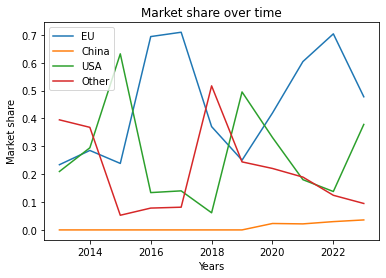

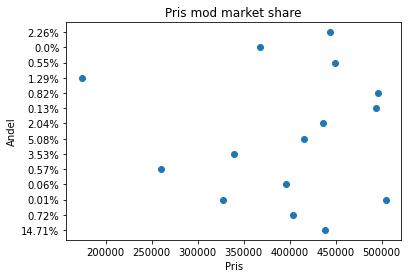

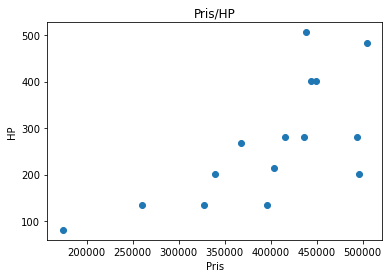

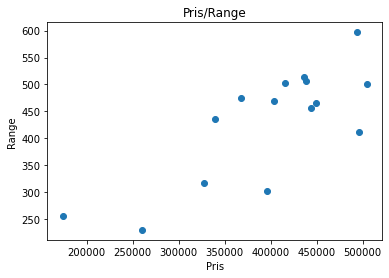

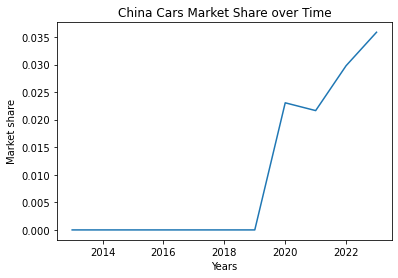

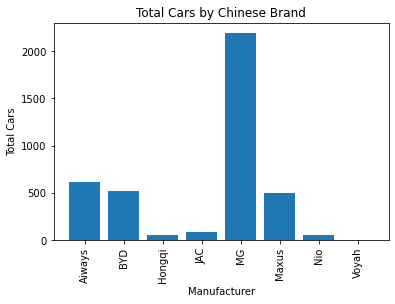

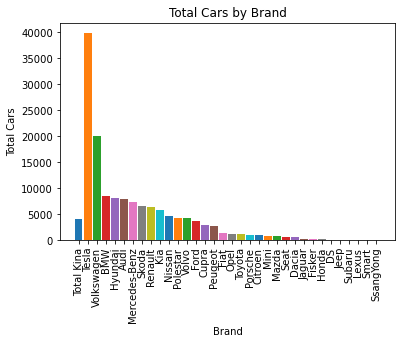

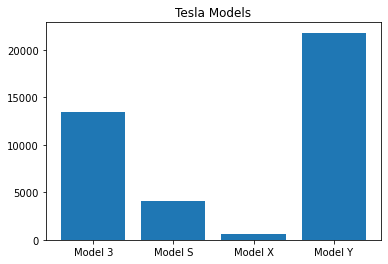

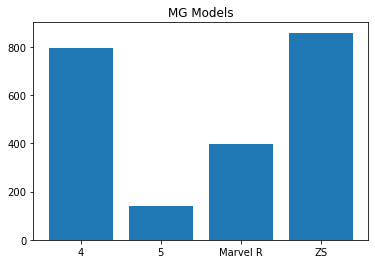

In [9]:
'''
Done
Hvem har størst market share? 
Pris mod market share
Pris/HP
Pris/Range
Hvordan ser det ud for kinesere isoleret?
Kinesere vs resten

Yet to come
Hvordan ser de største ud?
Størst udvikling i market share?
'''

#Market share over time
#plt.figure(figsize=(12, 6))
for region in region_shares.keys():
    plt.plot(years, region_shares[region])
plt.legend(['EU', 'China', 'USA', 'Other'])
plt.xlabel('Years')
plt.ylabel('Market share')
plt.title('Market share over time')
plt.show()

#Pris mod market share
# x = pris, y = andel
#plt.scatter(x,y)
#Kun for de 5 med højest andel
mængde = 15
plt.scatter(df_overview.Price[len(df_overview)-mængde:], df_overview.Andel[len(df_overview)-mængde:])
plt.title('Pris mod market share')
plt.xlabel('Pris')
plt.ylabel('Andel')
plt.show()

# Pris/HP
plt.scatter(df_overview.Price[len(df_overview)-mængde:], df_overview.HP[len(df_overview)-mængde:])
plt.title('Pris/HP')
plt.xlabel('Pris')
plt.ylabel('HP')
plt.show()

#Pris/Range
plt.scatter(df_overview.Price[len(df_overview)-mængde:], df_overview.Range[len(df_overview)-mængde:])
plt.title('Pris/Range')
plt.xlabel('Pris')
plt.ylabel('Range')
plt.show()

#Market share over time
plt.plot(years, region_shares['China'])
plt.xlabel('Years')
plt.ylabel('Market share')
plt.title('China Cars Market Share over Time')
plt.show()

#Total Cars by Chinese Brand
df_china = df_overview[df_overview['China'] == 1]
brand_totals = df_china.groupby('Manufacturer')['Antal'].sum()

plt.bar(brand_totals.index, brand_totals.values)
plt.title('Total Cars by Chinese Brand')
plt.xlabel('Manufacturer')
plt.ylabel('Total Cars')
plt.xticks(rotation=90)
plt.show()

#Kinesere by brands
df_china = df_overview[df_overview['China'] == 1]

total_kina = df_china['Antal'].sum() #Alle kinesere (samlet)
plt.bar('Total Kina', total_kina)
plt.title('Total Cars by Chinese Brands')


#Alle ikke CH-brands mod total CH. 
df_not_china = df_overview[df_overview['China'] == 0]
not_china_totals = df_not_china.groupby('Manufacturer')['Antal'].sum() #Alle ikke kinesere(unikke)
sorted_not_china_totals = not_china_totals.sort_values(ascending=False)

for i, (brand, total) in enumerate(sorted_not_china_totals.items()):
    plt.bar(brand, total, label=brand)

plt.title('Total Cars by Brand')
plt.xlabel('Brand')
plt.ylabel('Total Cars')
plt.xticks(rotation=90)
plt.show()

#Tesla models (Største i EU)
df_tesla = df_overview[df_overview['Manufacturer'] == 'Tesla']
df_tesla = df_tesla.groupby('Model')['Antal'].sum()
plt.bar(df_tesla.index, df_tesla.values)
plt.title('Tesla Models')
plt.show()

#MG (største kinesiske mærke i DK)
df_mg = df_overview[df_overview['Manufacturer'] == 'MG']
df_mg = df_mg.groupby('Model')['Antal'].sum()
plt.bar(df_mg.index, df_mg.values)
plt.title('MG Models')
plt.show()



## Estimering

In [10]:
#Bruger data hvor ms = 0 er inkluderet
N = df_dataset['ID'].unique().size
N
#print("market share value :", df['Market share'].size)
T = df_dataset['year'].unique().size
assert df_dataset.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T} data is = {df_dataset.shape[0]}, {N*T}')

Data has N=112 and T=11 data is = 1232, 1232


In [11]:
#Bruger data hvor ms = 0 er inkluderet
y = df_dataset['Market share'].values.reshape((N*T,1))
ones = np.ones((N*T,1))
Range = df_dataset['Range'].values.reshape((N*T,1)) #1
Price = df_dataset['Price'].values.reshape((N*T,1)) #2
HP = df_dataset['HP'].values.reshape((N*T,1)) #3
ChargeTime = df_dataset['ChargeTime'].values.reshape((N*T,1))  #4
China = df_dataset['China'].values.reshape((N*T,1)) #5
X = np.hstack([ones, Range, Price, HP, ChargeTime, China])

print(f' y \n {y[:2]} \n ones: \n {ones[:2]} \n X: {X[:2]} \n {X.size} \n')

 y 
 [[0.]
 [0.]] 
 ones: 
 [[1.]
 [1.]] 
 X: [[1.00000000e+00 4.00000000e+02 3.30825789e+05 2.01000000e+02
  3.40000000e+01 1.00000000e+00]
 [1.00000000e+00 4.00000000e+02 3.30825789e+05 2.01000000e+02
  3.40000000e+01 1.00000000e+00]] 
 7392 



In [12]:
#OLS estimation
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     7.527
Date:                Tue, 13 Feb 2024   Prob (F-statistic):           5.68e-07
Time:                        10:57:00   Log-Likelihood:                 2164.3
No. Observations:                1232   AIC:                            -4317.
Df Residuals:                    1226   BIC:                            -4286.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0091      0.007     -1.298      0.1

In [22]:
#Bruger data hvor ms = 0 er inkluderet
data = df_dataset_ms0

N = data['ID'].unique().size
N
#print("market share value :", df['Market share'].size)
T = data['year'].unique().size
assert data.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T} data is = {data.shape[0]}, {N*T}')

AssertionError: Error: data is not a balanced panel

In [13]:
#X = [ones, Range, Price, HP, ChargeTime, China])
N,J, K =1232, 6 ,1 #N, J, K
X.reshape(N, J, K)
X
#clogit(y, X, cov_type='Ainv',theta0=None, deriv=0, quiet=False)

array([[1.00000000e+00, 4.00000000e+02, 3.30825789e+05, 2.01000000e+02,
        3.40000000e+01, 1.00000000e+00],
       [1.00000000e+00, 4.00000000e+02, 3.30825789e+05, 2.01000000e+02,
        3.40000000e+01, 1.00000000e+00],
       [1.00000000e+00, 4.00000000e+02, 3.30825789e+05, 2.01000000e+02,
        3.40000000e+01, 1.00000000e+00],
       ...,
       [1.00000000e+00, 5.00000000e+02, 5.04768500e+05, 4.82000000e+02,
        5.50000000e+01, 1.00000000e+00],
       [1.00000000e+00, 5.00000000e+02, 5.04768500e+05, 4.82000000e+02,
        5.50000000e+01, 1.00000000e+00],
       [1.00000000e+00, 5.00000000e+02, 5.04768500e+05, 4.82000000e+02,
        5.50000000e+01, 1.00000000e+00]])

In [14]:
clogit(y, X, cov_type='Ainv',theta0=None, deriv=0, quiet=False)

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
def sim_data(N, J, theta) -> tuple: # Set the seed inside the function as well
    k = theta.size
    #x = random.normal(size=(N, J, k)) + np.linspace(3,5,J).reshape(1,J, 1)
    x = np.array([[[4 , 3],
        [1, 2]]])
    print(x.size,x.shape)
    
    #v = utiliy(theta, x) #returnere v = (x @ theta)
    v = np.array([[1], [-1]]).reshape(N,J)
    
    #e = genextreme.ppf(random.uniform(size=(N, J)), c=0)
    e = np.array([[1, 2]])
    
    #u = v + e # utility. Tillægger nytte støj i.i.d. ekstreme værdi
    u = np.array([[2,1]])
    
    print(f'v: {v} \n e: {e} \n u: {u}')

    # Find which choice that maximizes utility.
    y = u.argmax(axis=1)
    print(f'y: {y}') #y har kun en enkelt værdi så element 0 er den eneste værdi er den højeste. Element 0 er 2. 
    
    label = ['y', 'x']
    d=dict(zip(label, [y, x]))
    return d

In [ ]:
J=2          # number of alternatives index j=0,..,J-1
N=1          # number of observations
theta = np.array([1, -1]).reshape(-1,1) #True parameters. Reshape to make it a column vector
dta=sim_data(N, J, theta) #N observations(Antal "blokke"), J alternatives(Rækker), K attributes
print(f' theta = \n {theta} \n dta \n = {dta}')
res=clogit(dta['y'], dta['x'], deriv=0)  # Estimate c-logit model

4 (1, 2, 2)
v: [[ 1 -1]] 
 e: [[1 2]] 
 u: [[2 1]]
y: [0]
 theta = 
 [[ 1]
 [-1]] 
 dta 
 = {'y': array([0], dtype=int64), 'x': array([[[4, 3],
        [1, 2]]])}


C:\Users\Mikkel\AppData\Local\Temp\ipykernel_13388\1772663231.py:19: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  res=minimize(fun=Q, jac=dQ, x0=theta0, method='bfgs')


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 2)

In [ ]:
def clogit(y, x, cov_type='Ainv',theta0=None, deriv=0, quiet=False): 
	# Objective function and derivatives for 
    N, J, K, palt, xalt, xvars = labels(x)
    # labels and dimensions for plotting
    Qfun     = lambda theta, out:  Q_clogit(theta, y, x, out)

    if theta0 is None: 
    	theta0=np.zeros((K,1)) 

    res = estimation(Qfun, theta0, deriv, cov_type, parnames=['1', '2', '3', '4', '5', '6'])
    # v, p, dv = Qfun(res.theta_hat, out='predict')
    res.update(dict(zip(['yvar', 'xvars', 'N','K', 'n'], ['y', xvars, N, K, N])))

    if quiet==False:
        print('Conditional logit')
        print('Initial log-likelihood', -Qfun(theta0, 'Q'))
        print('Initial gradient\n', -Qfun(theta0, 'dQ'))
        print_output(res)

    return res

In [ ]:
def Q_clogit(theta, y, x, out='Q'):
    v = utiliy(theta, x) # v = x @ theta 	# Deterministic component of utility
    ll_i=logccp(v, y) 
    q_i= - ll_i   
    if out=='Q':
    	return np.mean(q_i)
    dv=x
    p=ccp(v)
    if out=='predict':  return v, p, dv         # Return predicted values
    N, J, K = dv.shape
    idx=y[:,] + J*np.arange(0, N)
    dvj=dv.reshape(N*J, K)[idx,:] 	# pick choice specific values corresponding to y 

    s_i = dvj -  np.sum(p.reshape(N,J,1)*dv, axis=1)
    g = -np.mean(s_i, axis=0)
    
    if out=='s_i': return s_i                     # Return s_i: NxK array with scores
    if out=='dQ':  return g;  # Return dQ: array of size K derivative of sample objective function

In [ ]:
def logsum(v, sigma=1): 
	# Expected max over iid extreme value shocks with scale parameter sigma(i.i.d bliver ikke brugt her?)
	# Logsum is reentered around maximum to obtain numerical stability (avoids overflow, but accepts underflow)
	max_v = v.max(axis=1).reshape(-1, 1) #Finder max værdi i hver column ergo Valgmulighed med størst nytte.
	return max_v + sigma*np.log(np.sum(np.exp((v-max_v)/sigma), 1)).reshape(-1, 1) #logit formel her. sigma = 1 gør det burde kunne lade sig gøre at fjerne det. Reshape for at få det tilbage til oprindelig form
	
def logccp(v, y=None, sigma=1):
    # Log of conditional choice probabilities 
    # If y = None return logccp corresponding to all choices
    # if y is Nx1 vector of choice indexes, return likelihood
    ev = logsum(v, sigma) 	# Expected utility (always larger than V)
    if y is not None:  		
    	N, J=v.shape #N = 1, J = 2
    	idx=y[:,] + J*np.arange(0, N)
    	v=v.reshape(N*J, 1)[idx] 	# pick choice specific values corresponding to y 
    return (v - ev)/sigma

In [ ]:
v = np.array([[1], [-1]]).reshape(N,J)
max_v = v.max(axis=1).reshape(-1, 1)
print(f'max_v = {max_v}, v = {v}')
sigma = 1 

hej = max_v + sigma*np.log(np.sum(np.exp((v-max_v)/sigma), 1)).reshape(-1, 1) #logit formel her. sigma = 1 gør det burde kunne lade sig gøre at fjerne det. Reshape for at få det tilbage til oprindelig form
print(f'hej = {hej}')


max_v = [[1]], v = [[ 1 -1]]
hej = [[1.12692801]]


In [ ]:
lol = np.exp(-2.12)
lol

0.12003162851145673

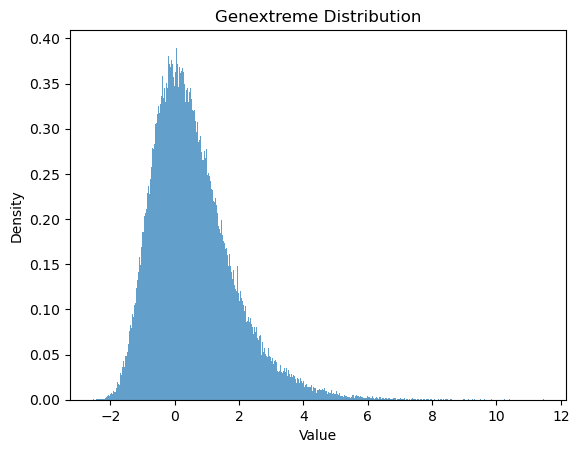

In [ ]:
#genextreme distribution for fejlledet.
import numpy as np
import matplotlib.pyplot as plt

# Generate 10,000 samples from the genextreme distribution
samples = genextreme.ppf(random.uniform(size=100_000), c=0)

# Plot the histogram of the samples
plt.hist(samples, bins=500, density=True, alpha=0.7)

# Add labels and title to the plot
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Genextreme Distribution')

# Show the plot
plt.show()


In [ ]:
v = [[1],[0.5]]
v = np.array(v)
max_v = v.max(axis=1).reshape(-1, 1)
print(f'max_v = {max_v}')

max_v = [[1. ]
 [0.5]]


In [ ]:
y =[1,2,3]
y = np.array(y)
N, J= 3, 4 
idx=y[:,] + J*np.arange(0, N)
idx
#v=v.reshape(N*J, 1)[idx]

array([ 1,  6, 11])

In [ ]:
x = 4*np.arange(0, 4)
x


array([ 0,  4,  8, 12])